In [1]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('scores.csv')

# Subtract 1 from all columns except 'gênero'
df.loc[:, df.columns != 'genero'] = df.loc[:, df.columns != 'genero'] - 1

# Display the updated DataFrame
print(df)

                     genero  janeiro2023  fevereiro2023  março2023  abril2023  \
0                   arrocha          9.7            5.1        3.4        9.0   
1                 sertanejo          9.7           10.0       10.0       10.0   
2   sertanejo universitario          9.7           10.0       10.0       10.0   
3                  agronejo          8.7            9.4       10.0       10.0   
4             sertanejo pop          5.2            8.7        9.3        7.9   
5              pop nacional          1.4            2.7        0.0        2.1   
6                      funk          2.6            0.6        1.5        2.1   
7              funk carioca          2.6            0.0        0.6        0.0   
8                     forro          9.1            4.8        3.4        7.7   
9                    pagode          7.0            4.8        0.7        5.6   
10              pagode novo          7.0            2.1        0.7        5.6   
11    sertanejo tradicional 

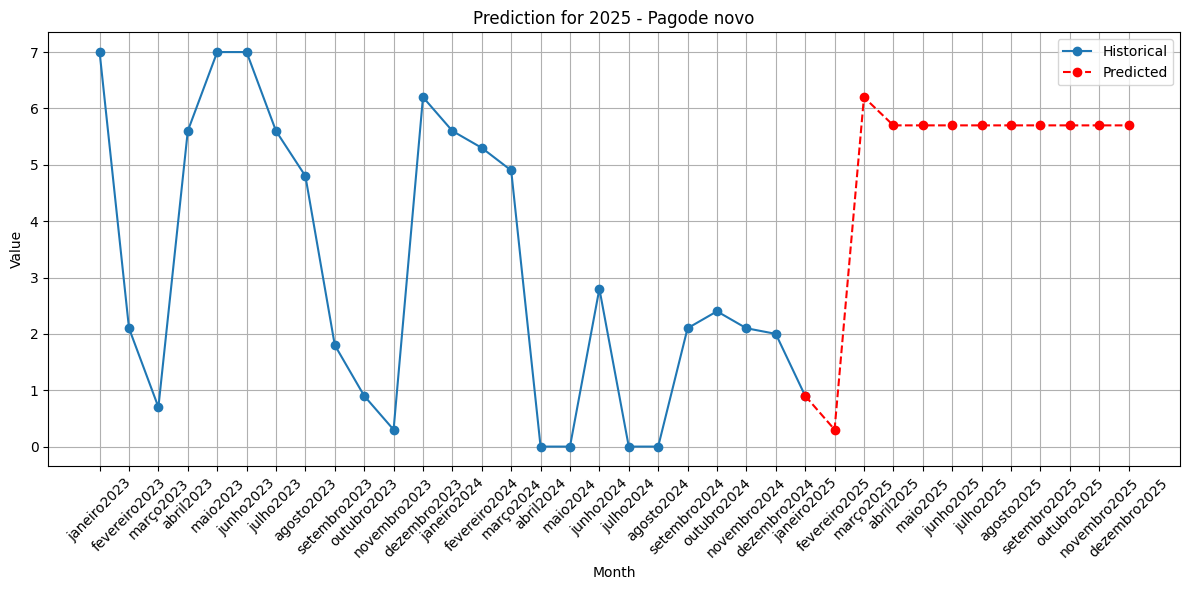

Predicted values for 2025 for pagode novo:
janeiro2025: 0.90
fevereiro2025: 0.30
março2025: 6.20
abril2025: 5.70
maio2025: 5.70
junho2025: 5.70
julho2025: 5.70
agosto2025: 5.70
setembro2025: 5.70
outubro2025: 5.70
novembro2025: 5.70
dezembro2025: 5.70


In [32]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def predict_2025_xgb(genre, df):
    if genre not in df["genero"].values:
        print(f"Genre '{genre}' not found.")
        return

    # Filter and sort columns
    genre_data = df[df["genero"] == genre].iloc[0]
    month_cols = [col for col in df.columns if col != "genero"]
    month_cols_sorted = sorted(month_cols, key=lambda x: pd.to_datetime(x, format="%B%Y", errors="coerce"))

    # Extract historical values including dezembro2024
    values = genre_data[month_cols_sorted].values.astype(float)

    # Prepare training data: use previous month as feature
    X_train = []
    y_train = []
    for i in range(1, len(values)):
        X_train.append([values[i - 1]])
        y_train.append(values[i])

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Train model
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Predict 12 months of 2025 iteratively starting from dezembro2024
    predictions = []
    last_value = values[-1]  # dezembro2024
    for _ in range(12):
        pred = model.predict([[last_value]])[0]
        predictions.append(pred)
        last_value = pred

    # Prepare full timeline
    # Combine monthsand values
    months_2025 = [f"{month}2025" for month in [
        "janeiro", "fevereiro", "março", "abril", "maio", "junho",
        "julho", "agosto", "setembro", "outubro", "novembro", "dezembro"
    ]]
    all_months = month_cols_sorted + months_2025
    all_values = list(values) + predictions  # Now we’ll actually use this
    
    # Plot
    plt.figure(figsize=(12, 6))
    # Plot historical data (up to dezembro2024)
    plt.plot(all_months[:25], all_values[:25], marker="o", label="Historical", linestyle="-")
    # Plot predicted data (starting from janeiro2025)
    plt.plot(all_months[24:], all_values[24:], marker="o", color="red", label="Predicted", linestyle="--")

    plt.xticks(rotation=45)
    plt.title(f"Prediction for 2025 - {genre.capitalize()}")
    plt.xlabel("Month")
    plt.ylabel("Value")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    # Print predictions
    print(f"Predicted values for 2025 for {genre}:")
    for m, v in zip(months_2025, predictions):
        print(f"{m}: {v:.2f}")

# Example usage
predict_2025_xgb("pagode novo", df)

In [52]:
import numpy as np
from sklearn.metrics import mean_squared_error

def calculate_mse_threshold(predictions, actuals):
    # Convert to numpy arrays
    predictions = np.array(predictions)
    actuals = np.array(actuals)

    # Calculate errors
    errors = predictions - actuals

    # Standard deviation of errors
    sigma = np.std(errors)

    # Number of samples (12 months)
    N = 12

    # Threshold formula
    lambda_threshold = sigma * np.sqrt(2 * np.log(N))
    print(lambda_threshold)
    # Actual MSE
    mse = mean_squared_error(actuals, predictions)

    # Print results
    print(f"Standard deviation of errors (σ): {sigma:.4f}")
    print(f"MSE threshold (λ): {lambda_threshold:.4f}")
    print(f"Actual MSE: {mse:.4f}")

    # Optional: flag if MSE exceeds threshold
    if mse > lambda_threshold:
        print("⚠️ MSE exceeds threshold — possible anomaly or poor fit.")
    else:
        print("✅ MSE is within expected bounds.")
        
    return lambda_threshold


In [55]:
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

def predict_2024_from_2023(genre, df):
    if genre not in df["genero"].values:
        print(f"Genre '{genre}' not found.")
        return

    # Filter the data for the selected genre
    genre_data = df[df["genero"] == genre].iloc[0]

    # Define month columns
    months_2023 = [f"{month}2023" for month in [
        "janeiro", "fevereiro", "março", "abril", "maio", "junho",
        "julho", "agosto", "setembro", "outubro", "novembro", "dezembro"
    ]]
    months_2024 = [f"{month}2024" for month in [
        "janeiro", "fevereiro", "março", "abril", "maio", "junho",
        "julho", "agosto", "setembro", "outubro", "novembro", "dezembro"
    ]]

    # Extract values
    values_2023 = genre_data[months_2023].values.astype(float)
    values_2024_actual = genre_data[months_2024].values.astype(float)

    # Prepare training data: use previous month to predict next
    X_train = []
    y_train = []
    for i in range(1, len(values_2023)):
        X_train.append([values_2023[i - 1]])
        y_train.append(values_2023[i])

    X_train = np.array(X_train)
    y_train = np.array(y_train)

    # Train model
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)

    # Predict 12 months of 2024 iteratively
    predictions_2024 = []
    last_value = values_2023[-1]  # dezembro2023
    for _ in range(12):
        pred = model.predict([[last_value]])[0]
        predictions_2024.append(pred)
        last_value = pred

    # Calculate accuracy
    mse = mean_squared_error(values_2024_actual, predictions_2024)
    mae = mean_absolute_error(values_2024_actual, predictions_2024)
    correlation = np.corrcoef(values_2024_actual, predictions_2024)[0, 1]
    lambda_threshold = calculate_mse_threshold(predictions_2024, values_2024_actual)
    print(lambda_threshold)

    # Print results
    print(f"\nGenre: {genre}")
    print("Predicted vs Actual for 2024:")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Correlation Coefficient (r): {correlation:.4f}")
    
    return {
        "gênero": genre,
        "MSE": round(mse, 4),
        "MAE": round(mae, 4),
        "correlation": round(correlation, 4),
    }

results = []
for genre in df["genero"].unique():
    metrics = predict_2024_from_2023(genre, df)
    if metrics:
        results.append(metrics)

# Create DataFrame and save to CSV
results_df = pd.DataFrame(results)
results_df.to_csv("genre_accuracy_metrics.csv", index=False)
print("\n✅ Results saved to genre_accuracy_metrics.csv")


5.149665881664983
Standard deviation of errors (σ): 2.3100
MSE threshold (λ): 5.1497
Actual MSE: 12.6637
⚠️ MSE exceeds threshold — possible anomaly or poor fit.
5.149665881664983

Genre: arrocha
Predicted vs Actual for 2024:
Mean Squared Error (MSE): 12.6637
Mean Absolute Error (MAE): 3.1069
Correlation Coefficient (r): -0.6161
1.0365745867300757
Standard deviation of errors (σ): 0.4650
MSE threshold (λ): 1.0366
Actual MSE: 0.2818
✅ MSE is within expected bounds.
1.0365745867300757

Genre: sertanejo
Predicted vs Actual for 2024:
Mean Squared Error (MSE): 0.2818
Mean Absolute Error (MAE): 0.4063
Correlation Coefficient (r): 0.3842
1.43433080656153
Standard deviation of errors (σ): 0.6434
MSE threshold (λ): 1.4343
Actual MSE: 0.6119
✅ MSE is within expected bounds.
1.43433080656153

Genre: sertanejo universitario
Predicted vs Actual for 2024:
Mean Squared Error (MSE): 0.6119
Mean Absolute Error (MAE): 0.5050
Correlation Coefficient (r): 0.3264
1.4397580143163449
Standard deviation of er

c:\Users\ltert\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ltert\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\ltert\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ltert\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


1.4631527958409123
Standard deviation of errors (σ): 0.6563
MSE threshold (λ): 1.4632
Actual MSE: 0.5308
✅ MSE is within expected bounds.
1.4631527958409123

Genre: funk
Predicted vs Actual for 2024:
Mean Squared Error (MSE): 0.5308
Mean Absolute Error (MAE): 0.3163
Correlation Coefficient (r): nan
2.7598115661423575
Standard deviation of errors (σ): 1.2380
MSE threshold (λ): 2.7598
Actual MSE: 3.5848
⚠️ MSE exceeds threshold — possible anomaly or poor fit.
2.7598115661423575

Genre: funk carioca
Predicted vs Actual for 2024:
Mean Squared Error (MSE): 3.5848
Mean Absolute Error (MAE): 1.6326
Correlation Coefficient (r): 0.2341
4.331521739951231
Standard deviation of errors (σ): 1.9430
MSE threshold (λ): 4.3315
Actual MSE: 24.6966
⚠️ MSE exceeds threshold — possible anomaly or poor fit.
4.331521739951231

Genre: forro
Predicted vs Actual for 2024:
Mean Squared Error (MSE): 24.6966
Mean Absolute Error (MAE): 4.5740
Correlation Coefficient (r): nan
7.453423816225813
Standard deviation of 

c:\Users\ltert\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ltert\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\ltert\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ltert\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\ltert\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


0.0
Standard deviation of errors (σ): 0.0000
MSE threshold (λ): 0.0000
Actual MSE: 1.2543
⚠️ MSE exceeds threshold — possible anomaly or poor fit.
0.0

Genre: oktoberfest
Predicted vs Actual for 2024:
Mean Squared Error (MSE): 1.2543
Mean Absolute Error (MAE): 1.1200
Correlation Coefficient (r): nan
1.1453906367771116
Standard deviation of errors (σ): 0.5138
MSE threshold (λ): 1.1454
Actual MSE: 0.5666
✅ MSE is within expected bounds.
1.1453906367771116

Genre: pop lgbtq+ brasileira 
Predicted vs Actual for 2024:
Mean Squared Error (MSE): 0.5666
Mean Absolute Error (MAE): 0.5568
Correlation Coefficient (r): -0.0893
5.917805524339701
Standard deviation of errors (σ): 2.6545
MSE threshold (λ): 5.9178
Actual MSE: 7.1523
⚠️ MSE exceeds threshold — possible anomaly or poor fit.
5.917805524339701

Genre: mpb
Predicted vs Actual for 2024:
Mean Squared Error (MSE): 7.1523
Mean Absolute Error (MAE): 2.3578
Correlation Coefficient (r): -0.4137
4.739417440157232
Standard deviation of errors (σ): 

c:\Users\ltert\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ltert\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


3.140033616606526
Standard deviation of errors (σ): 1.4085
MSE threshold (λ): 3.1400
Actual MSE: 2.3706
✅ MSE is within expected bounds.
3.140033616606526

Genre: rave funk
Predicted vs Actual for 2024:
Mean Squared Error (MSE): 2.3706
Mean Absolute Error (MAE): 1.2529
Correlation Coefficient (r): -0.3407
2.3590660636043013
Standard deviation of errors (σ): 1.0582
MSE threshold (λ): 2.3591
Actual MSE: 1.2318
✅ MSE is within expected bounds.
2.3590660636043013

Genre: arrochadeira
Predicted vs Actual for 2024:
Mean Squared Error (MSE): 1.2318
Mean Absolute Error (MAE): 0.8174
Correlation Coefficient (r): 0.2870
5.378933392638689
Standard deviation of errors (σ): 2.4128
MSE threshold (λ): 5.3789
Actual MSE: 8.0631
⚠️ MSE exceeds threshold — possible anomaly or poor fit.
5.378933392638689

Genre: musica tocantinense
Predicted vs Actual for 2024:
Mean Squared Error (MSE): 8.0631
Mean Absolute Error (MAE): 2.5268
Correlation Coefficient (r): -0.1687
2.1743019904212724
Standard deviation of 

c:\Users\ltert\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\ltert\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [59]:
import pandas as pd

# Load your existing CSV (skip comment lines if needed)
df = pd.read_csv("genre_accuracy_metrics.csv", comment="#")

# Fixed threshold
threshold = 5.1497

# Compare MSE values and add status column
df["MSE status"] = df["MSE"].apply(lambda x: "above" if x > threshold else "below")

# Save to new CSV with threshold as first line
with open("genre_accuracy_metrics_with_status.csv", "w", encoding="utf-8") as f:
    f.write(f"# MSE threshold (λ): {threshold}\n")
    df.to_csv(f, index=False)
    
# Total number of genres
total_genres = 23

# Count how many are below the threshold
accurate_count = df[df["MSE status"] == "below"].shape[0]

# Calculate percentage
accuracy_percentage = (accurate_count / total_genres) * 100

# Print result
print(f"\n✅ Accurate genres: {accurate_count} out of {total_genres}")
print(f"🎯 Accuracy rate: {accuracy_percentage:.2f}%")
average_mse = df["MSE"].mean()
print(f"\n📊 Average MSE across all genres: {average_mse:.4f}")

print("✅ CSV saved with threshold as first line")


✅ Accurate genres: 17 out of 23
🎯 Accuracy rate: 73.91%

📊 Average MSE across all genres: 4.8351
✅ CSV saved with threshold as first line
